# Introduction to Convolutional Neural Networks

In [84]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt


I want to create a model to distinguish between circles and squares in images. First, I create a dataset containing images of both classes.

In [85]:
class ShapesDataset(Dataset):
    def __init__(self, num_samples, image_size=28):
        self.num_samples = num_samples
        self.image_size = image_size
        self.data, self.labels = self.generate_data(num_samples, image_size)
        
    def generate_data(self, num_samples, image_size):
        data = []
        labels = []
        for _ in range(num_samples):
            label = np.random.randint(0, 2)
            image = np.zeros((image_size, image_size), dtype=np.float32)
            if label == 0:
                # Draw a square
                side = np.random.randint(5, image_size // 2)
                top_left_x = np.random.randint(0, image_size - side)
                top_left_y = np.random.randint(0, image_size - side)
                image[top_left_x:top_left_x+side, top_left_y:top_left_y+side] = 1.0
            else:
                # Draw a circle
                radius = np.random.randint(5, image_size // 4)
                center_x = np.random.randint(radius, image_size - radius)
                center_y = np.random.randint(radius, image_size - radius)
                y, x = np.ogrid[:image_size, :image_size]
                mask = (x - center_x)**2 + (y - center_y)**2 <= radius**2
                image[mask] = 1.0
            data.append(image)
            labels.append(label)
        return torch.tensor(data).unsqueeze(1), torch.tensor(labels)
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Create the dataset and dataloaders
train_dataset = ShapesDataset(num_samples=1000)
test_dataset = ShapesDataset(num_samples=200)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

Lets display some examples

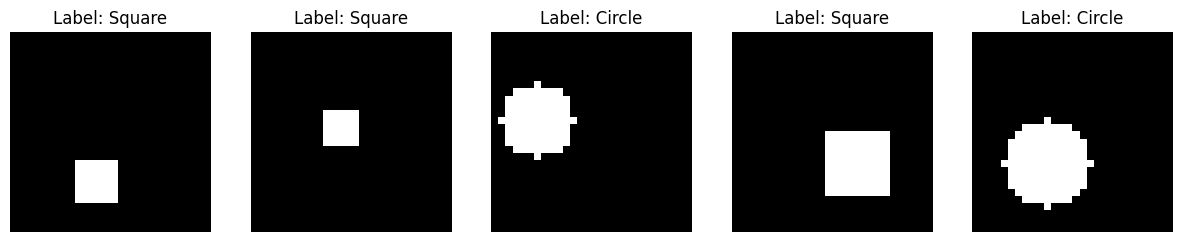

In [86]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    image, label = train_dataset[i]
    axes[i].imshow(image.squeeze(), cmap='gray')
    axes[i].set_title(f"Label: {'Square' if label.item() == 0 else 'Circle'}")
    axes[i].axis('off')
plt.show()

Lets create a network using pixels as features

In [87]:
image, label = train_dataset[0]

print("Original", image.shape)
# The first step is flattening the image to enter the network
nn.Flatten(1)(image).shape

Original torch.Size([1, 28, 28])


torch.Size([1, 784])

In [88]:
model = nn.Sequential(
    nn.Flatten(start_dim=1),
    nn.Linear(784, 20),
    nn.Tanh(),
    nn.Linear(20, 2),
    nn.Softmax(dim=1)
)
sum(p.nelement() for p in model.parameters())

15742

There are some problems with this solution:
- The interaction of every pair of pixels is taken into account in the linear layer. This creates a very large number of parameters to learn.
- The model is very sensitive to image translations, because each pixel is considered a feature.
- The locality is completelly missed. Borders, for example, cannot be found.

## Convolutional Neural Networks
A convolution is a mathematical operation that combines two sets of information.

In computer vision, a convolution transform an image using a kernel. Convolution transforms pixels into features, that takes into account in a particular way the relations of each pixel with its neighbors.

In [89]:
def manual_convolution(input_data, kernel):
    # Get dimensions
    input_h, input_w = input_data.shape
    kernel_h, kernel_w = kernel.shape

    # Calculate output dimensions
    output_h = input_h - kernel_h + 1
    output_w = input_w - kernel_w + 1

    # Initialize the output
    output = torch.zeros((output_h, output_w), dtype=torch.float32, device=input_data.device)

    # Perform the convolution operation
    for i in range(output_h):
        for j in range(output_w):
            # Extract the region of interest
            region = input_data[i:i+kernel_h, j:j+kernel_w]
            # Perform element-wise multiplication and sum the result
            output[i, j] = torch.sum(region * kernel)
    
    return output


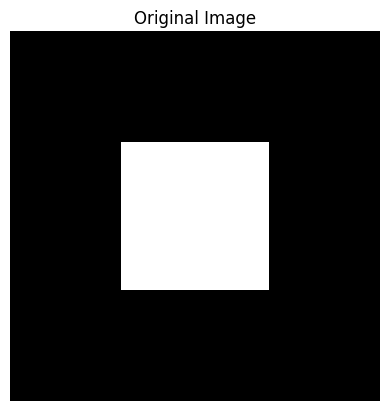

In [90]:
def display_image(image, title='',*, cmap='gray', **kwargs):
    plt.imshow(image, cmap=cmap, **kwargs)
    plt.title(title)
    plt.axis('off')
    plt.show()

image = np.zeros((10, 10), dtype=np.float32)
image[3:7, 3:7] = 1.0

# Display the original image
display_image(image, title='Original Image')

# Convert the image to a PyTorch tensor and add a batch dimension and a channel dimension
image_tensor = torch.tensor(image).unsqueeze(0).unsqueeze(0)

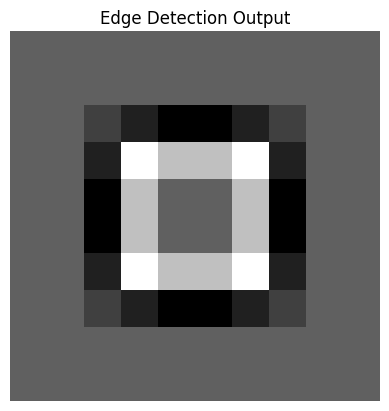

In [91]:
def show_by_kernel(image_tensor, kernel, title):
    output = F.conv2d(image_tensor, kernel, padding='same').squeeze().numpy()
    display_image(output, title)

edge_detection_kernel = torch.tensor([[
    [-1, -1, -1], 
    [-1, 8, -1], 
    [-1, -1, -1]]], dtype=torch.float32).unsqueeze(0)
show_by_kernel(image_tensor, edge_detection_kernel, 'Edge Detection Output')


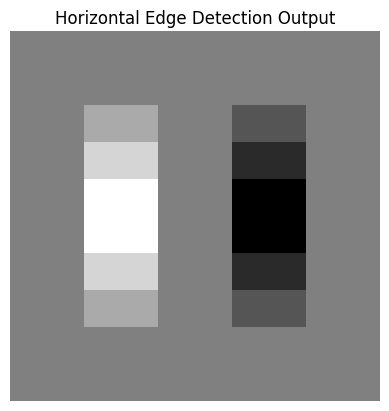

In [92]:
vertical_edge_kernel = torch.tensor([[
    [-1, 0, 1], 
    [-1, 0, 1], 
    [-1, 0, 1]]], dtype=torch.float32).unsqueeze(0)
show_by_kernel(image_tensor, vertical_edge_kernel, 'Horizontal Edge Detection Output')


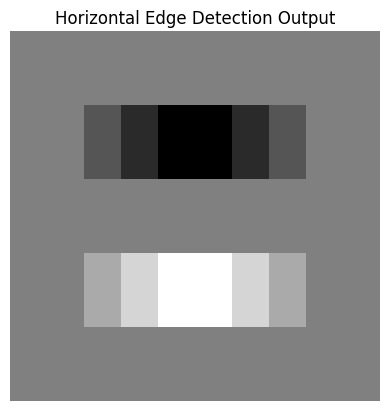

In [93]:
horizontal_edge_kernel = torch.tensor([[
    [1, 1, 1], 
    [0, 0, 0], 
    [-1, -1, -1]]], dtype=torch.float32).unsqueeze(0)
show_by_kernel(image_tensor, horizontal_edge_kernel, 'Horizontal Edge Detection Output')


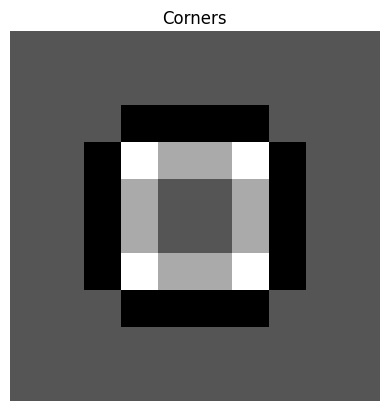

In [94]:
corner_kernel = torch.tensor([[
    [0, -1, 0], 
    [-1, 4, -1], 
    [0, -1, 0]]], dtype=torch.float32).unsqueeze(0)
show_by_kernel(image_tensor, corner_kernel, 'Corners')

Convolutions find new features that contains information a pixel region, so now they can include information about borders.

If we train a network using convoluted values, we can provide better information with less size:
- Learn the kernels in the first layers

Additionally, we would need to reduce the size of the images on each layer:
- Reduce the dimensionality, so the number of parameters
- Translation invariance, by summarizing feautures in regions
- Hierarchical features, by producing more abstract features per layers
- Noise reduction 

CNNs are neural networks that use convolutions to create higher-level features based on the input images:
- In convolutional layers, the kernels are learnt
- All operations are differenciable, so can be learned by gradient descent and backpropagation

In [95]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1)
        self.fc = nn.Linear(3 * 3, 2)  # Adjust the dimensions accordingly
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(self.tanh(self.conv1(x)))
        x = self.pool(self.tanh(self.conv2(x)))
        x = x.view(x.shape[0], -1)  # Flatten the tensor
        x = self.fc(x)
        x = self.softmax(x)
        return x

model = SimpleCNN()


In [96]:
sum(p.nelement() for p in model.parameters())

40

Lets train the model

In [100]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # update
        optimizer.step()
        running_loss += loss.item()
    if epoch % (num_epochs // 10) == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")

print("Training complete")

# Evaluation loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total}%")


Epoch [1/30], Loss: 0.3827009868621826
Epoch [4/30], Loss: 0.35139657169580457
Epoch [7/30], Loss: 0.3340273433923721
Epoch [10/30], Loss: 0.3246662983298302
Epoch [13/30], Loss: 0.3205544325709343
Epoch [16/30], Loss: 0.3186906751990318
Epoch [19/30], Loss: 0.31747633039951323
Epoch [22/30], Loss: 0.3166865649819374
Epoch [25/30], Loss: 0.31611920177936553
Epoch [28/30], Loss: 0.3156686368584633
Training complete
Accuracy: 100.0%


Lets explore now what are the convolutions learned by the model while training

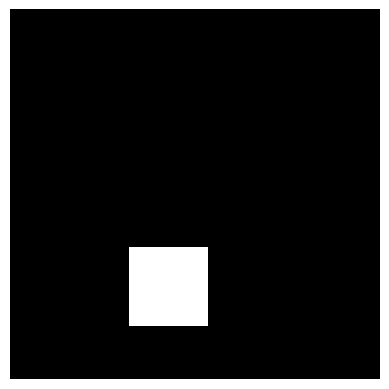

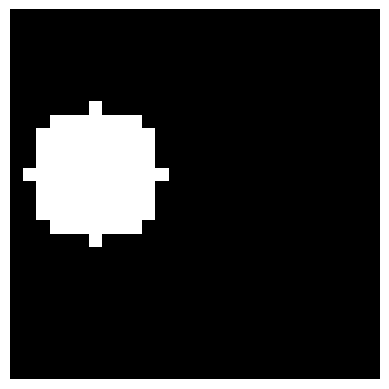

In [101]:
square_1 = [img for img, cls in train_dataset if cls == 0][0]
circle_1 = [img for img, cls in train_dataset if cls == 1][0]
display_image(square_1.squeeze())
display_image(circle_1.squeeze())


In [102]:
model.conv1.weight

Parameter containing:
tensor([[[[-0.2954, -0.1634,  0.2150],
          [ 0.9363, -0.9184,  0.0893],
          [-0.8331,  0.9195, -0.3006]]]], requires_grad=True)

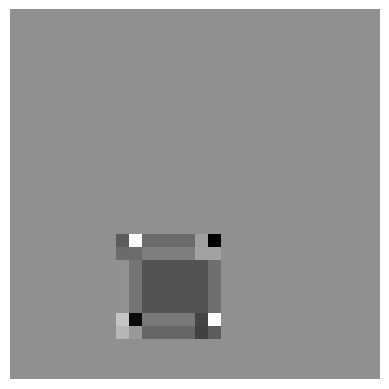

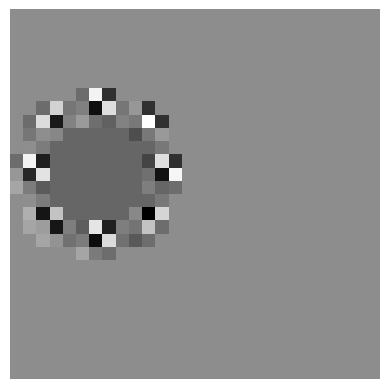

In [103]:
with torch.no_grad():
    image = model.conv1(square_1).squeeze()
    display_image(image)
    image = model.conv1(circle_1).squeeze()
    display_image(image)


In [63]:
model.conv2.weight

Parameter containing:
tensor([[[[-0.1635,  0.7515,  0.6694],
          [ 0.5562,  0.5664,  0.8671],
          [ 1.4100,  1.0094,  0.0176]]]], requires_grad=True)

Lets apply the pooling and the second convolution to both examples

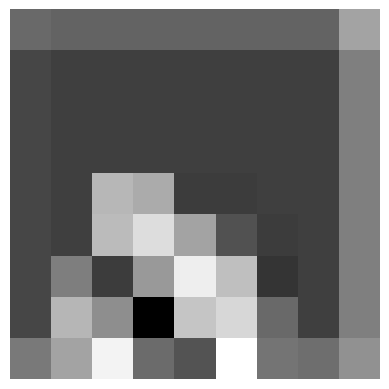

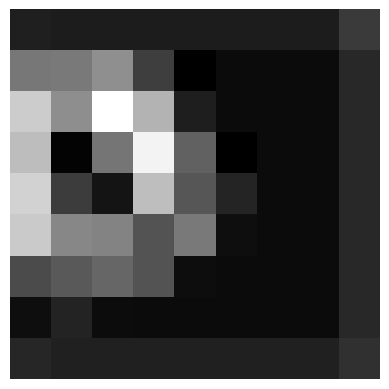

In [104]:
with torch.no_grad():
    image = model.conv2(model.pool(torch.tanh(model.conv1(square_1)))).squeeze()
    display_image(image)
    image = model.conv2(model.pool(torch.tanh(model.conv1(circle_1)))).squeeze()
    display_image(image)

And then we apply the last pooling

In [19]:
image = model.conv2(model.pool(torch.tanh(model.conv1(circle_1)))).squeeze()
image

tensor([[-0.1104, -0.0260, -0.7731, -0.7063, -1.2214, -0.0260, -0.0260, -0.0260,
         -0.0967],
        [-0.7779, -1.3333, -3.2177, -2.9517, -2.2912, -1.1396,  0.0940,  0.0940,
         -0.0177],
        [-1.5468, -1.5705, -3.2668, -2.0757, -2.2180, -1.4085, -0.9903,  0.0940,
         -0.0177],
        [-2.3072, -2.1356, -3.0868, -1.3060, -2.1428, -1.5557, -1.5364,  0.0940,
         -0.0177],
        [-2.0686, -1.8269, -2.4589, -1.1544, -2.8646, -2.2394, -2.1420,  0.0940,
         -0.0177],
        [-1.2965, -1.4423, -2.2565, -1.4919, -2.8562, -1.6937, -1.1451,  0.0940,
         -0.0177],
        [-0.6348, -1.4155, -2.7832, -2.8467, -2.5475, -1.3486, -0.5567,  0.0940,
         -0.0177],
        [-0.0308,  0.0940, -0.6480, -1.0733, -1.0769, -0.3687,  0.0940,  0.0940,
         -0.0177],
        [-0.0973, -0.0283, -0.0283, -0.0283, -0.0283, -0.0283, -0.0283, -0.0283,
         -0.1052]], grad_fn=<SqueezeBackward0>)

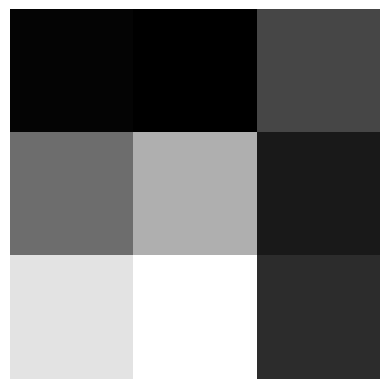

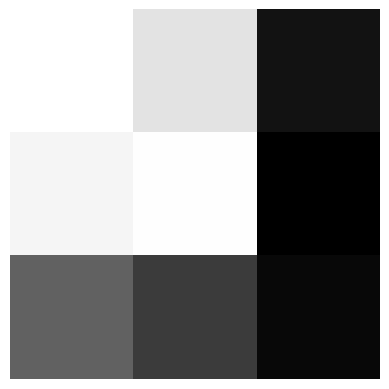

In [105]:
with torch.no_grad():
    image = model.pool(torch.tanh(model.conv2(
        model.pool(torch.tanh(model.conv1(square_1)))))).squeeze()
    display_image(image)
    image = model.pool(torch.tanh(model.conv2(
        model.pool(torch.tanh(model.conv1(circle_1)))))).squeeze()
    display_image(image)

Lets show the results for some of the circles and squares

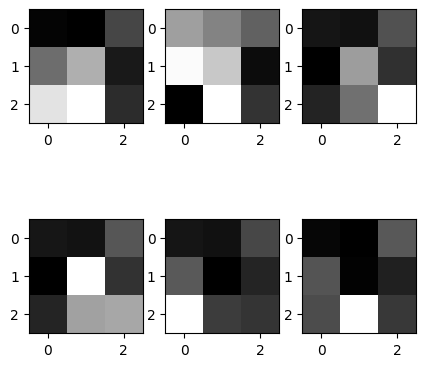

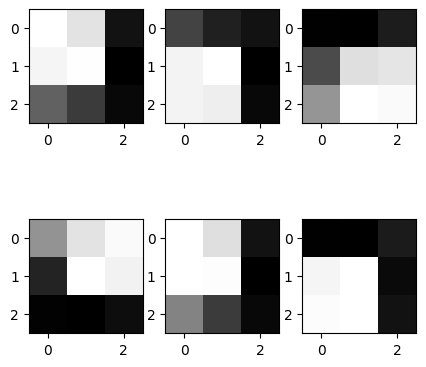

In [106]:
squares = [img for img, cls in train_dataset if cls == 0][:6]
circles = [img for img, cls in train_dataset if cls == 1][:6]

with torch.no_grad():
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(5, 5))
    for i, ax in enumerate(axes.flat):
        image = model.pool(torch.tanh(model.conv2(
            model.pool(torch.tanh(model.conv1(squares[i])))))).squeeze()
        ax.imshow(image, cmap='gray')
    plt.show()

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(5, 5))
    for i, ax in enumerate(axes.flat):
        image = model.pool(torch.tanh(model.conv2(
            model.pool(torch.tanh(model.conv1(circles[i])))))).squeeze()
        ax.imshow(image, cmap='gray')
    plt.show()
        

In real, more complex applications, we usually performs different parallel convolutions to the same input. The result of each of the convolutions is stored in a different chanel of the output

In [22]:
# single convolution kernel
nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1).weight.shape


torch.Size([1, 1, 3, 3])

In [23]:
image = torch.randn((10, 1, 28, 28))
nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1)(image).shape

torch.Size([10, 1, 28, 28])

In [24]:
# multiple convolution kernels
nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, padding=1).weight.shape


torch.Size([5, 1, 3, 3])

In [25]:
image = torch.randn((10, 1, 28, 28))
nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, padding=1)(image).shape

torch.Size([10, 5, 28, 28])

For multipe inputs channels, actual kernels have one more dimmension.

In [26]:
nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3, padding=1).weight.shape

torch.Size([1, 3, 3, 3])

In [34]:
image = torch.randn((10, 3, 28, 28))
nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3, padding=1)(image).shape

torch.Size([10, 1, 28, 28])

In [35]:
# Final case, multiple inputs, multiple outputs
nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3, padding=1).weight.shape

torch.Size([5, 3, 3, 3])

In [36]:
image = torch.randn((10, 3, 28, 28))
nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3, padding=1)(image).shape

torch.Size([10, 5, 28, 28])

Now, lets explore the kernel size

In [37]:
image = torch.randn((1, 1, 28, 28))
nn.Conv2d(in_channels=1, out_channels=5, kernel_size=7)(image).shape

torch.Size([1, 5, 22, 22])

In [38]:
# padding

image = torch.randn((1, 1, 28, 28))
nn.Conv2d(in_channels=1, out_channels=5, kernel_size=7, padding=3)(image).shape

torch.Size([1, 5, 28, 28])

In [27]:
# padding, auto

image = torch.randn((1, 1, 28, 28))
print(nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, padding='same')(image).shape)
print(nn.Conv2d(in_channels=1, out_channels=5, kernel_size=7, padding='same')(image).shape)

torch.Size([1, 5, 28, 28])
torch.Size([1, 5, 28, 28])


Lets change the model to use multiple kernels per layer

In [107]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.fc = nn.Linear(16 * 3 * 3, 2)  # out_channels * (28 // 3 //3) * (28 // 3 //3)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(self.tanh(self.conv1(x)))
        x = self.pool(self.tanh(self.conv2(x)))
        x = x.view(-1, 16 * 3 * 3)  # Flatten the tensor
        x = self.fc(x)
        x = self.softmax(x)
        return x

model = SimpleCNN()


In [108]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")

print("Training complete")

# Evaluation loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total}%")


Epoch [1/10], Loss: 0.6625106239318848
Epoch [2/10], Loss: 0.5275445830821991
Epoch [3/10], Loss: 0.38671438992023466
Epoch [4/10], Loss: 0.33868208080530166
Epoch [5/10], Loss: 0.3259234854578972
Epoch [6/10], Loss: 0.32091271251440046
Epoch [7/10], Loss: 0.318436793088913
Epoch [8/10], Loss: 0.31696875602006913
Epoch [9/10], Loss: 0.3161762818694115
Epoch [10/10], Loss: 0.31550128012895584
Training complete
Accuracy: 100.0%


In color images, the input images has three channels, so we need to adjust the conv2d parameters.

In this example, I will differentiate between two classes:
- class 0: yellow squares
- class 1: red squares and yellow circles

In [30]:
# channels are R, G, B. yellow = R+G

def create_square(image_size, color='rgb'):
    image = np.zeros((3, image_size, image_size), dtype=np.float32)
    side = np.random.randint(5, image_size // 2)
    top_left_x = np.random.randint(0, image_size - side)
    top_left_y = np.random.randint(0, image_size - side)
    for idx, c in enumerate('rgb'):
        if c in color:
            image[idx, top_left_x:top_left_x+side, top_left_y:top_left_y+side] = 1.0
    return image

def create_circle(image_size, color='rgb'):
    image = np.zeros((3, image_size, image_size), dtype=np.float32)
    radius = np.random.randint(5, image_size // 4)
    center_x = np.random.randint(radius, image_size - radius)
    center_y = np.random.randint(radius, image_size - radius)
    y, x = np.ogrid[:image_size, :image_size]
    mask = (x - center_x)**2 + (y - center_y)**2 <= radius**2
    for idx, c in enumerate('rgb'):
        if c in color:
            image[idx, mask] = 1.0
    return image

class ShapesDataset2(Dataset):
    def __init__(self, num_samples, image_size=28):
        self.num_samples = num_samples
        self.image_size = image_size
        self.data, self.labels = self.generate_data(num_samples, image_size)
        
    def generate_data(self, num_samples, image_size):
        data = []
        labels = []
        for _ in range(num_samples):
            label = np.random.randint(0, 2)
            # image = np.zeros((3, image_size, image_size), dtype=np.float32)
            if label == 0:
                # Draw a yellow square
                image = create_square(image_size, 'rg')
            else:
                if np.random.rand() < 0.5:
                    image = create_circle(image_size, 'rg')
                else:
                    image = create_square(image_size, 'r')
                    
            data.append(image)
            labels.append(label)
        return torch.tensor(data), torch.tensor(labels)
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Create the dataset and dataloaders
train_dataset = ShapesDataset2(num_samples=1000)
test_dataset = ShapesDataset2(num_samples=200)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)


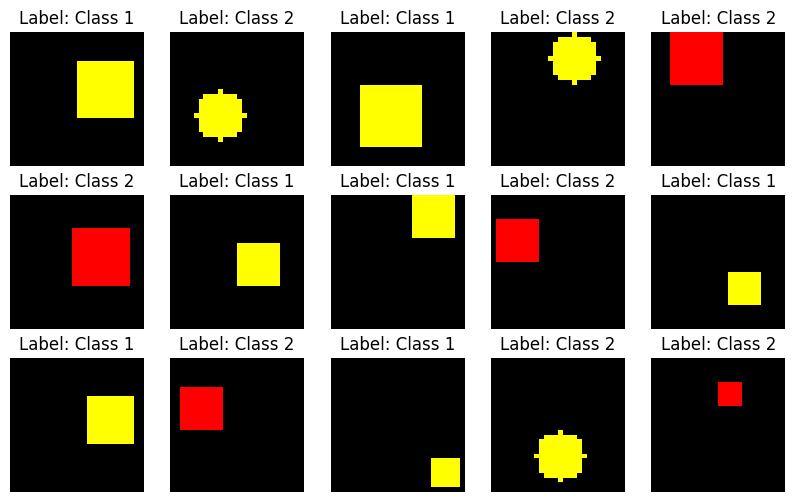

In [31]:
# Display some samples
fig, axes = plt.subplots(3, 5, figsize=(10,6))
for i in range(15):
    row = i // 5
    col = i % 5
    ax = axes[row, col]
    image, label = train_dataset[i]
    ax.imshow(image.squeeze().permute(1, 2, 0).numpy(), cmap='gray')
    ax.set_title(f"Label: {'Class 1' if label.item() == 0 else 'Class 2'}")
    ax.axis('off')
plt.show()

In [32]:
class SimpleCNNColor(nn.Module):
    def __init__(self):
        super(SimpleCNNColor, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=2, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)
        self.conv2 = nn.Conv2d(in_channels=2, out_channels=2, kernel_size=3, padding=1)
        self.fc = nn.Linear(2 * 3 * 3, 2)  # out_channels * (28 // 3 //3) * (28 // 3 //3)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(self.tanh(self.conv1(x)))
        x = self.pool(self.tanh(self.conv2(x)))
        x = x.view(-1, 2 * 3* 3)  # Flatten the tensor
        x = self.fc(x)
        x = self.softmax(x)
        return x

model = SimpleCNNColor()


In [33]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")

print("Training complete")

# Evaluation loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total}%")


Epoch [1/20], Loss: 0.690698674917221
Epoch [2/20], Loss: 0.6760739988088608
Epoch [3/20], Loss: 0.5899596452713013
Epoch [4/20], Loss: 0.4913878318667412
Epoch [5/20], Loss: 0.4186711359024048
Epoch [6/20], Loss: 0.3832064336538315
Epoch [7/20], Loss: 0.3600574341416359
Epoch [8/20], Loss: 0.34855923652648924
Epoch [9/20], Loss: 0.3414148083329201
Epoch [10/20], Loss: 0.3360304379463196
Epoch [11/20], Loss: 0.33224761188030244
Epoch [12/20], Loss: 0.32950308233499526
Epoch [13/20], Loss: 0.32698207050561906
Epoch [14/20], Loss: 0.3253274381160736
Epoch [15/20], Loss: 0.3236540925502777
Epoch [16/20], Loss: 0.3225877806544304
Epoch [17/20], Loss: 0.3216029766201973
Epoch [18/20], Loss: 0.32075270742177964
Epoch [19/20], Loss: 0.3203831812739372
Epoch [20/20], Loss: 0.31974393367767334
Training complete
Accuracy: 99.5%


In [46]:
# out_channels, in_channels, h, w
model.conv1.weight.shape

torch.Size([2, 3, 3, 3])

In [34]:
display(model.conv1.weight[0])
torch.sum(model.conv1.weight[0], dim=(1, 2))

tensor([[[ 0.1142, -0.0814,  0.3382],
         [ 0.2167,  0.0068,  0.0394],
         [-0.1432,  0.1826,  0.0133]],

        [[-0.1805, -0.1668, -0.1890],
         [-0.0004, -0.3144, -0.2551],
         [-0.0945,  0.0573, -0.2393]],

        [[ 0.0631,  0.1403,  0.1172],
         [ 0.1049,  0.0879, -0.0803],
         [ 0.1509,  0.1878,  0.0775]]], grad_fn=<SelectBackward0>)

tensor([ 0.6867, -1.3827,  0.8495], grad_fn=<SumBackward1>)

In [48]:
display(model.conv1.weight[1])
torch.sum(model.conv1.weight[1], dim=(1, 2))

tensor([[[ 0.1945,  0.1357,  0.2259],
         [ 0.1215, -0.0032, -0.0010],
         [ 0.2175,  0.0334,  0.0452]],

        [[ 0.3938,  0.3972,  0.4325],
         [ 0.3714,  0.3048,  0.4370],
         [ 0.4167,  0.4384,  0.3441]],

        [[-0.0167,  0.0504,  0.1786],
         [ 0.0733, -0.0423,  0.1818],
         [ 0.1189,  0.0037, -0.0732]]], grad_fn=<SelectBackward0>)

tensor([0.9695, 3.5359, 0.4744], grad_fn=<SumBackward1>)

Lets now explore the results of applying those convolutions to the three types of objects we have in the dataset

In [49]:
def display_image_color(image, title='',*, cmap='gray'):
    plt.imshow(image.squeeze().permute(1, 2, 0).numpy(), cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()


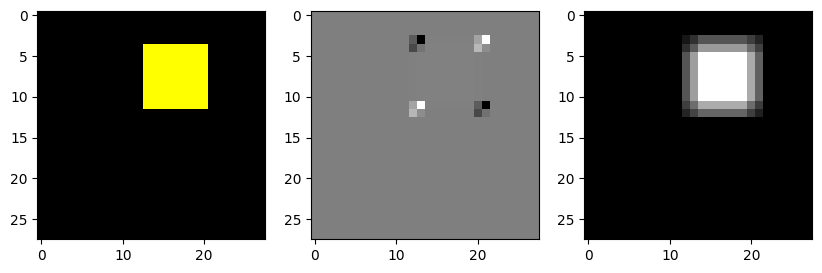

In [50]:
obj = torch.tensor(create_square(28,'rg'))
fig, axes = plt.subplots(1, 3, figsize=(10,6))
axes[0].imshow(obj.squeeze().permute(1, 2, 0).numpy(), cmap='gray')
with torch.no_grad():
    c1 = model.conv1(obj)
axes[1].imshow(c1[0], cmap='gray')
axes[2].imshow(c1[1], cmap='gray')

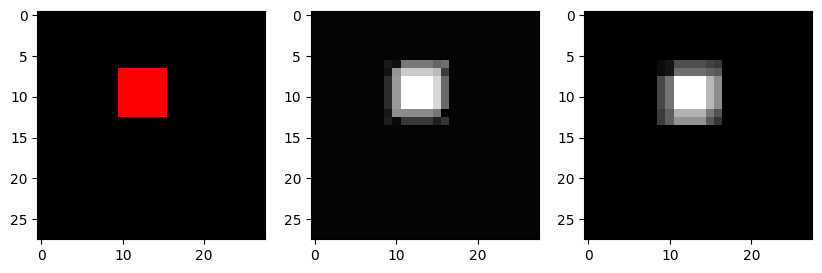

In [51]:
obj = torch.tensor(create_square(28,'r'))
fig, axes = plt.subplots(1, 3, figsize=(10,6))
axes[0].imshow(obj.squeeze().permute(1, 2, 0).numpy(), cmap='gray')
with torch.no_grad():
    c1 = model.conv1(obj)
axes[1].imshow(c1[0], cmap='gray')
axes[2].imshow(c1[1], cmap='gray')

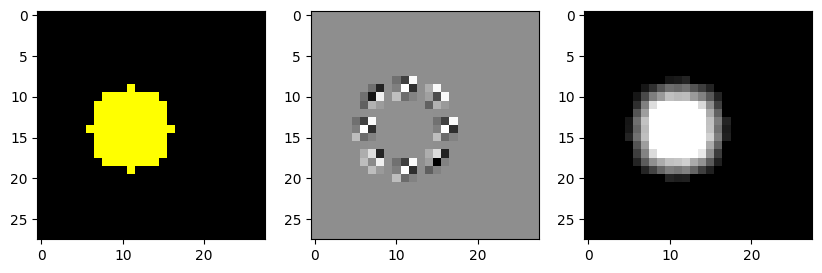

In [52]:
obj = torch.tensor(create_circle(28,'rg'))
fig, axes = plt.subplots(1, 3, figsize=(10,6))
axes[0].imshow(obj.squeeze().permute(1, 2, 0).numpy(), cmap='gray')
with torch.no_grad():
    c1 = model.conv1(obj)
axes[1].imshow(c1[0], cmap='gray')
axes[2].imshow(c1[1], cmap='gray')

Remember the classes
- class 0: yellow squares
- class 1: red squares and yellow circles

Here you can see that on red objects, no borders are extracte because it is not necesary in order to distinguish the class